# Create a Simple 1D Regression MLP

This code create a simple, three-layer MLP that predicts average buoyancy in the lower troposhere ($B_L$) from lower free-tropospheric subsaturation ($\mathrm{SUBSAT_L}$).

**Resources:**
- https://www.machinelearningexpedition.com/how-to-train-multilayer-perceptron-in-pytorch/
- https://sebastianraschka.com/teaching/pytorch-1h/#3-seeing-models-as-computation-graphs

## Import Necessary Packages

In [36]:
import torch
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from scipy import stats
from torch.utils.data import TensorDataset,DataLoader
warnings.filterwarnings('ignore')

## Load and Explore Data

We will use an MLP for regression to predict $B_L$ from $\mathrm{SUBSAT_L}$. We load in daily-mean $\mathrm{SUBSAT_L}$ (K) and $B_L$ (m/s<sup>2</sup>) for Central India.

In [132]:
file = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc'
data = xr.open_dataset(file)
data = data.sel(lat=slice(18,24),lon=slice(76,83))

x = data.subsat.load()
y = data.bl.load()

We can generate exploratory plots to better understand the distribution of the data, and the relationship between $\mathrm{SUBSAT_L}$ and $B_L$.

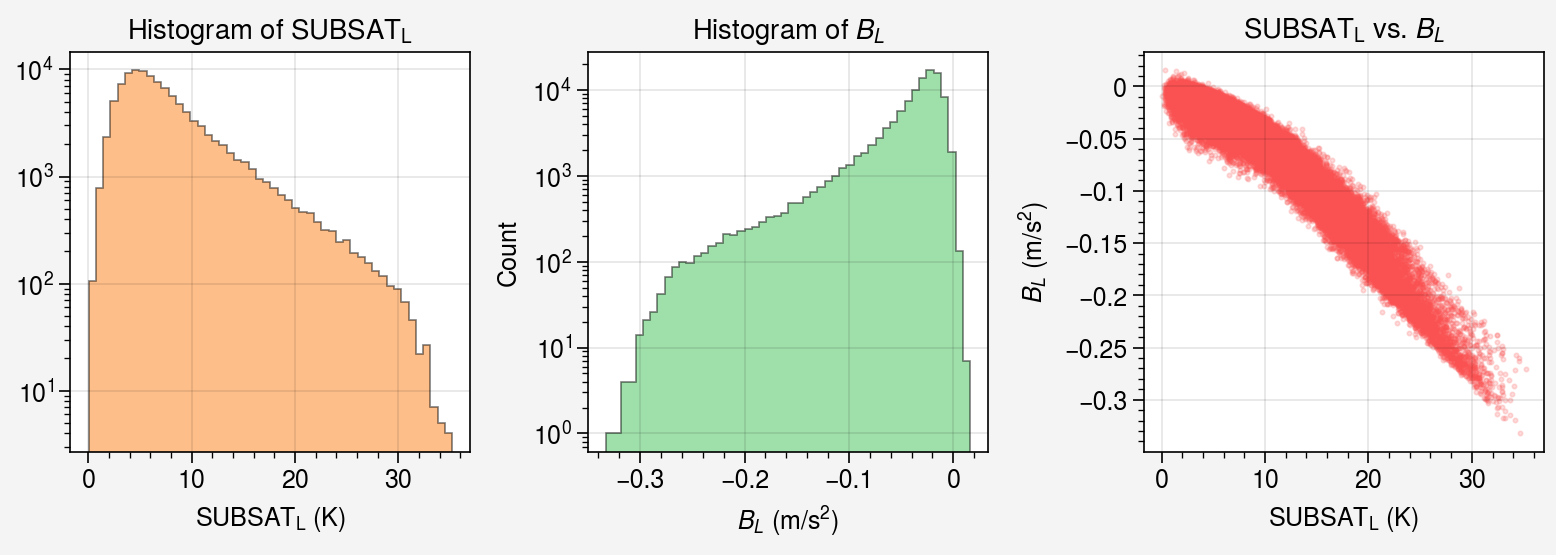

In [133]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=False)
axs[0].format(title='Histogram of $SUBSAT_L$',xlabel='$SUBSAT_L$ (K)',yscale='log',yformatter='log')
axs[1].format(title='Histogram of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Count',yscale='log',yformatter='log')
axs[2].format(title='$SUBSAT_L$ vs. $\mathit{B_L}$',xlabel='$SUBSAT_L$ (K)',ylabel='$\mathit{B_L}$ (m/s$^2$)')
axs[0].hist(x.values.flatten(),bins=50,filled=True,color='orange6',edgecolor='k',alpha=0.5)
axs[1].hist(y.values.flatten(),bins=50,filled=True,color='green6',edgecolor='k',alpha=0.5)
axs[2].scatter(x.values.flatten(),y.values.flatten(),color='red6',marker='.',markersize=10,alpha=0.2)
pplt.show()

## Preprocess the Input and Target Data

The `subset()` function allows us to temporally subset our input (*x*) and target (*y*) data by selecting specific years. It will later be used to divide our data into training, validation, and test sets. When dealing with temporal data, you must maintain temporal continuity within each set while ensuring no overlap between them. The splitting method should be carefully selected to ensure a high likelihood of consistent distribution shapes across all sets.

The `array()` function reformats our subsetted data to make it compatible with PyTorch. It flattens our 3D Xarray.DataArrays (time × lat × lon) into 1D NumPy arrays. We maintain 64-bit precision during this conversion to ensure accuracy in subsequent processing steps.

In [134]:
def subset(x,y,startyear,endyear):
    years   = np.arange(startyear,endyear+1)
    xsubset = x.sel(time=x['time.year'].isin(years))
    ysubset = y.sel(time=y['time.year'].isin(years))
    def array(xsubset,ysubset):
        return xsubset.values.flatten().astype(np.float64),ysubset.values.flatten().astype(np.float64)
    xarray,yarray = array(xsubset,ysubset)
    return xarray,yarray

The `normalize()` function applies z-score normalization to our data, centering it around 0 with a standard deviation of 1. It calculates normalization parameters (the mean and standard deviation) if not provided. We typically derive these parameters from the training set and apply them to the training, validation, and test sets. This ensures that the model learns to generalize from the training data (mitigate overfitting).

In [135]:
def normalize(array,mean=None,std=None):
    if mean is None:
        mean = np.mean(array)
    if std is None:
        std  = np.std(array)
    return (array-mean)/std,mean,std

The `preprocess()` function streamlines our data preparation workflow, combining splitting, array conversion, and normalization steps for training, validation, and test sets.

In [136]:
def preprocess(x,y,years,training=True,normparams=None):
    xarray,yarray = subset(x,y,years[0],years[1])
    if training:
        xnorm,xmean,xstd = normalize(xarray)
        ynorm,ymean,ystd = normalize(yarray)
        normparams = {'xmean':xmean,'xstd':xstd,'ymean':ymean,'ystd':ystd}
    else:
        if normparams is None:
            raise ValueError("'normparams' must be provided for validation and test sets.")
        xnorm,_,_ = normalize(xarray,normparams['xmean'],normparams['xstd'])
        ynorm,_,_ = normalize(yarray,normparams['ymean'],normparams['ystd'])
    xtensor = torch.FloatTensor(xnorm)
    ytensor = torch.FloatTensor(ynorm)
    return (xtensor,ytensor,normparams) if training else (xtensor,ytensor)

# def preprocess(x,y,trainyears,valyears,testyears):
#     # Split data into training, validation, and test sets
#     xtrainarray,ytrainarray = subset(x,y,trainyears[0],trainyears[1])
#     xvalarray,yvalarray     = subset(x,y,valyears[0],valyears[1])
#     xtestarray,ytestarray   = subset(x,y,testyears[0],testyears[1])
#     # Normalize using training parameters
#     xtrainnorm,xtrainmean,xtrainstd = normalize(xtrainarray)
#     xvalnorm,_,_  = normalize(xvalarray,xtrainmean,xtrainstd)
#     xtestnorm,_,_ = normalize(xtestarray,xtrainmean,xtrainstd)
#     ytrainnorm,ytrainmean,ytrainstd = normalize(ytrainarray)
#     yvalnorm,_,_  = normalize(yvalarray,ytrainmean,ytrainstd)
#     ytestnorm,_,_ = normalize(ytestarray,ytrainmean,ytrainstd)
#     # Convert to tensors
#     xtraintensor,ytraintensor = torch.FloatTensor(xtrainnorm),torch.FloatTensor(ytrainnorm)
#     xvaltensor,yvaltensor     = torch.FloatTensor(xvalnorm),torch.FloatTensor(yvalnorm)
#     xtesttensor,ytesttensor   = torch.FloatTensor(xtestnorm),torch.FloatTensor(ytestnorm)
    return xtraintensor,ytraintensor,xvaltensor,yvaltensor,xtesttensor,ytesttensor

We will work with smaller timespans within our 21-year dataset. We allocate 6 years for training (2000-2005), 2 years for validation (2006-2007), and 2 years for testing (2008-2009).

In [137]:
trainyears = (2000,2005)
valyears   = (2006,2007)
testyears  = (2008,2009)

xtrain,ytrain,normparams = preprocess(x,y,trainyears,training=True,normparams=False)
xval,yval   = preprocess(x,y,valyears,training=False,normparams=normparams)
xtest,ytest = preprocess(x,y,testyears,training=False,normparams=normparams)

# xtrain,ytrain,xval,yval,xtest,ytest = preprocess(x,y,trainyears,valyears,testyears)

## Create Data Loaders

Now that we have preprocessed the training, validation, and test sets, we create a custom class that inherits from PyTorch's `TensorDataset`. This class is tailored to handle our specific data structure, where each sample has a single input feature ($\mathrm{CAPE_L}$) and a single target value ($B_L$). The class reshapes input and target tensors to ensure they have the shape (*n*<sub>samples</sub>, 1), where 1 represents the single feature for both input and target. This structure optimizes compatibility with PyTorch's DataLoader, an iterator designed to efficiently load data in batches.

In [138]:
class DATASET(TensorDataset):
    def __init__(self,xtensor,ytensor):
        self.inputs  = xtensor.view(-1,1)
        self.targets = ytensor.view(-1,1)
    def __getitem__(self,index):
        onex = self.inputs[index]
        oney = self.targets[index]
        return onex,oney
    def __len__(self):
        return self.targets.shape[0]

In [139]:
traindataset = DATASET(xtrain,ytrain)
valdataset   = DATASET(xval,yval)
testdataset  = DATASET(xtest,ytest)

Now we can use PyTorch’s `DataLoader` class to sample from our datasets. Processing data in batches is more memory-efficient and can lead to faster training. `BATCHSIZE`, a model hyperparameter (external parameter set before training begins, denoted by all-caps), determines the number of samples processed simultaneously. We create DataLoaders for the training, validation, and test sets. For the training set, we enable random shuffling. Shuffling at each epoch prevents the model from memorizing the order of the data, enhancing its ability to generalize. For the validation and test sets, we don't enable shuffling, since the order is not important for evaluation.

In [140]:
def factors(n):
    factors = []
    for i in range(1,int(n**0.5)+1):
        if n%i==0:
            factors.append(i)
            if i!=n//i:
                factors.append(n//i)
    for factor in factors:
        if factor>=300 and factor<=1000:
            print(f'  Batch Size: {factor} ({n//factor} batches total)')

print('Train Batch Size Options:')
factors(30912) # xtrain.shape
print('Validation/Test Batch Size Options:')
factors(10304) # xval.shape

Train Batch Size Options:
  Batch Size: 966 (32 batches total)
  Batch Size: 736 (42 batches total)
  Batch Size: 672 (46 batches total)
  Batch Size: 644 (48 batches total)
  Batch Size: 552 (56 batches total)
  Batch Size: 483 (64 batches total)
  Batch Size: 448 (69 batches total)
  Batch Size: 368 (84 batches total)
  Batch Size: 336 (92 batches total)
  Batch Size: 322 (96 batches total)
Validation/Test Batch Size Options:
  Batch Size: 736 (14 batches total)
  Batch Size: 644 (16 batches total)
  Batch Size: 448 (23 batches total)
  Batch Size: 368 (28 batches total)
  Batch Size: 322 (32 batches total)


In [141]:
BATCHSIZE   = 322
trainloader = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
valloader   = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
testloader  = DataLoader(dataset=testdataset,batch_size=BATCHSIZE,shuffle=False)

## Define the Model

We define our MLP architecture by creating a class that inherits from PyTorch's `nn.Module`, the base class for all neural network modules in PyTorch. The `__init__()` constructor defines the network's structure, and the `forward()` method specifies how the input data passes through the network.

In the network below, input data passes through the first linear layer, then through a specified activation function, repeats this process for the hidden layer, and then goes through the output layer. Activation functions introduce non-linearity into the model. Without them, the network would just be a complex linear function, incapable of learning non-linear relationships. We chose ReLU specifically because it only allows non-negative values, which aligns well with our goal of predicting (non-negative) precipitation values.

In [142]:
class MLP(torch.nn.Module):
    def __init__(self,inputsize,hiddensize,outputsize,activation):
        super(MLP,self).__init__()                  
        self.activation = activation()      
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputsize,hiddensize),  # Input layer to first hidden layer
            self.activation,
            torch.nn.Linear(hiddensize,hiddensize), # First hidden layer to second hidden layer
            self.activation,
            torch.nn.Linear(hiddensize,outputsize))  # Second hidden layer to output layer
    def forward(self,x):
        logits = self.layers(x)
        return logits

## Model Initialization

We now set the remaining hyperparameters for our model. `INPUTSIZE` and `OUTPUTSIZE` are both set to 1, reflecting our single input feature ($\mathrm{CAPE_L}$) and single output feature (l$B_L$). `HIDDENSIZE` defines the number of neurons in each hidden layer. `ACTIVATION` determines the activation to use after the first two layers. These hyperparameters are used to initialize our MLP model.

In [143]:
INPUTSIZE  = 1
OUTPUTSIZE = 1
HIDDENSIZE = 64
ACTIVATION = torch.nn.Softmax

model = MLP(INPUTSIZE,HIDDENSIZE,OUTPUTSIZE,ACTIVATION)
print(model)

MLP(
  (activation): Softmax(dim=None)
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Softmax(dim=None)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softmax(dim=None)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


We can find out the number of trainable parameters for our model. Trainable paramaters are paramaters that are updated during training (where `required_grad=True`).

In [144]:
nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters:', nparams)

Number of trainable parameters: 4353


## Train the Model

We configure the training process by setting up the loss function (`CRITERION`) and `OPTIMIZER`. For regression tasks like ours, MSE is an appropriate loss function. We choose the Adam optimizer for its adaptive learning rate capabilities. `LEARNING` determines the learning rate, or step size for weight updates during training. You want this value to balance rapid convergence (higher values) and stability (lower values). The optimizer is initialized with the model's parameters and the specified learning rate.

In [145]:
CRITERION = torch.nn.MSELoss()
LEARNING  = 0.005
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=LEARNING)

We now create a training loop that iterates over the entire dataset for a specified number of epochs (`NEPOCHS`). For each epoch, we train and validate the model using the `train()` and `validate()` functions, respectively. Both functions process the data in batches and calculate the average loss for the entire dataset, but they serve different purposes.

The `train()` function sets the model to training mode, computing gradients and updating the model's weights. This allows the model to learn from the training data to minimize the loss. The `validate()` function sets the model to evaluation mode, and operates without computing gradients. We use it with our validation set to monitor performance and check for overfitting, without adjusting the weights.

After each epoch, we store the training and validation losses, and print the results to track the model's progress over time.

In [146]:
def train(model,dataloader,criterion,optimizer):
    model.train()
    runningloss = 0.0
    for inputs,targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()*inputs.size(0)
    return runningloss/len(dataloader.dataset)

def validate(model,dataloader,criterion):
    model.eval()
    runningloss = 0.0
    with torch.no_grad():
        for inputs,targets in dataloader:
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
    return runningloss/len(dataloader.dataset)

In [147]:
NEPOCHS     = 20
trainlosses = []
vallosses   = []

for epoch in range(NEPOCHS):
    trainloss = train(model,trainloader,CRITERION,OPTIMIZER)
    valloss   = validate(model,valloader,CRITERION)
    trainlosses.append(trainloss)
    vallosses.append(valloss)
    print(f'Epoch {epoch+1}/{NEPOCHS}, Train Loss: {trainloss:.4f}, Val Loss: {valloss:.4f}')

Epoch 1/20, Train Loss: 0.9127, Val Loss: 0.6969
Epoch 2/20, Train Loss: 0.4598, Val Loss: 0.3057
Epoch 3/20, Train Loss: 0.2361, Val Loss: 0.1719
Epoch 4/20, Train Loss: 0.1151, Val Loss: 0.0742
Epoch 5/20, Train Loss: 0.0629, Val Loss: 0.0564
Epoch 6/20, Train Loss: 0.0539, Val Loss: 0.0517
Epoch 7/20, Train Loss: 0.0508, Val Loss: 0.0499
Epoch 8/20, Train Loss: 0.0495, Val Loss: 0.0491
Epoch 9/20, Train Loss: 0.0488, Val Loss: 0.0484
Epoch 10/20, Train Loss: 0.0484, Val Loss: 0.0484
Epoch 11/20, Train Loss: 0.0482, Val Loss: 0.0481
Epoch 12/20, Train Loss: 0.0481, Val Loss: 0.0483
Epoch 13/20, Train Loss: 0.0482, Val Loss: 0.0479
Epoch 14/20, Train Loss: 0.0481, Val Loss: 0.0479
Epoch 15/20, Train Loss: 0.0480, Val Loss: 0.0480
Epoch 16/20, Train Loss: 0.0479, Val Loss: 0.0480
Epoch 17/20, Train Loss: 0.0479, Val Loss: 0.0479
Epoch 18/20, Train Loss: 0.0479, Val Loss: 0.0479
Epoch 19/20, Train Loss: 0.0479, Val Loss: 0.0481
Epoch 20/20, Train Loss: 0.0481, Val Loss: 0.0479


We can plot the training and validation loss to make sure they are decreasing over time.

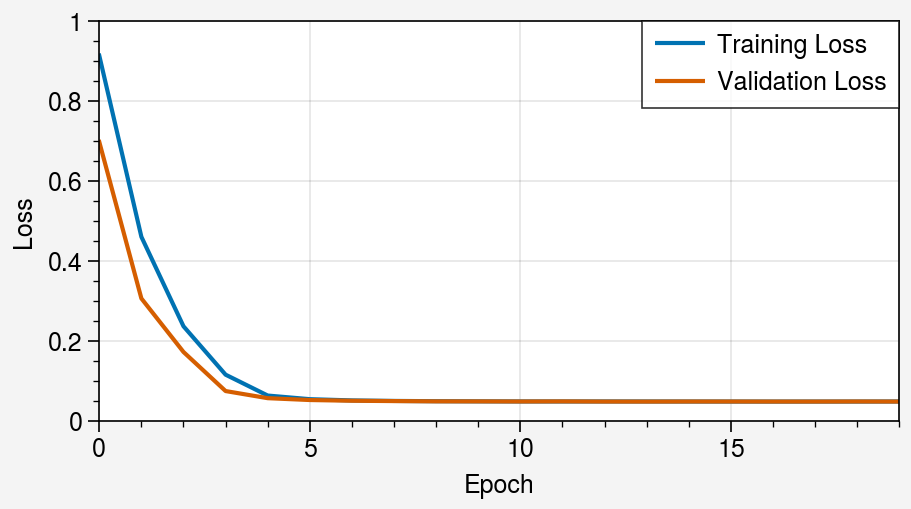

In [148]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refheight=2,refwidth=4)
ax.format(xlabel='Epoch',xticks=5,ylabel='Loss',ylim=(0,1))
ax.plot(trainlosses,label='Training Loss')
ax.plot(vallosses,label='Validation Loss')
ax.legend(loc='ur',ncols=1)

## Evaluate the Model

After training and validating,we can evaluate the model on the test set. The `test()` function sets the model to evaluate mode, and then passes the data in batches to get predictions and the average loss.

In [149]:
def test(model,dataloader,criterion):
    model.eval()
    runningloss = 0.0
    alloutputs = []
    with torch.no_grad():
        for inputs,targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
            alloutputs.append(outputs.cpu().numpy())
    return runningloss/len(dataloader.dataset),np.array(np.concatenate(alloutputs).flatten())

In [156]:
testloss,ypred = test(model,testloader,CRITERION)
print(f'Test Loss: {testloss:.4f}')

Test Loss: 0.0552


We can denormalize out results and plot them:

In [170]:
def denormalize(normdata,mean,std):
    return normdata*std+mean

denormypred = denormalize(ypred,normparams['ymean'],normparams['ystd'])
denormytest = denormalize(ytest,normparams['ymean'],normparams['ystd'])

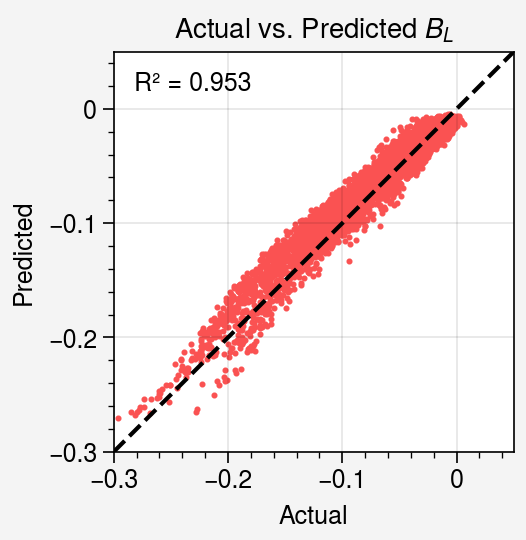

In [172]:
slope,intercept,rvalue,pvalue,stderr = stats.linregress(denormytest,denormypred)
rsquared = rvalue**2

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
ax.format(title='Actual vs. Predicted $\mathit{B_L}$',xlabel='Actual',xlim=(-0.3,0.05),xticks=0.1,ylabel='Predicted',ylim=(-0.3,0.05),yticks=0.1)
ax.scatter(denormytest,denormypred,color='red6',marker='.',markersize=10)
minvalue = min(ax.get_xlim()[0],ax.get_ylim()[0])
maxvalue = max(ax.get_xlim()[1],ax.get_ylim()[1])
ax.plot([minvalue,maxvalue],[minvalue,maxvalue],'k--')
ax.text(0.05,0.95,f'R² = {rsquared:.3f}',transform=ax.transAxes,verticalalignment='top',horizontalalignment='left')
pplt.show()